<a href="https://colab.research.google.com/github/kdidi99/ml_heidelberg/blob/main/naive-bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Exercise 3**

Team members:

*   Rudolf Braun
*   Jannik Schacht
*   Kieran Didi

#Data preparation

In [1]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_validate

In [2]:
digits = load_digits() 
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

Data filtering (indeed we have 361 instances with a dimension of 8x8=64 each)



In [4]:
X_all = data
y_all = target

X_filter = X_all[np.logical_or(3 == y_all, 9 == y_all)]
y_filter = y_all[np.logical_or(3 == y_all, 9 == y_all)]
X_filter.shape

(363, 64)

Visualize a few numbers to make sure we have the correct images

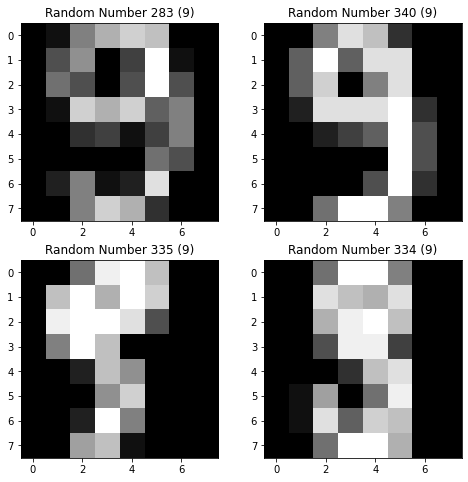

In [6]:
fig, axs = plt.subplots(2, 2)
sel = np.random.randint(low=0, high=361, size=4)
for r, x, y in zip(sel, [0, 0, 1, 1], [0, 1, 0, 1]):
    img = X_filter[r, :].reshape((8,8))
    assert 2 == len(img.shape)
    axs[x, y].imshow(img, interpolation="nearest", cmap="gray")
    axs[x, y].set_title(f"Random Number {r} ({y_filter[r]})")
fig.set_size_inches(8, 8)

#Dimension Reduction

In [7]:
#separate 3's and 9's
X_three = X_filter[3 == y_filter]
X_nine = X_filter[9 == y_filter]

#calculate the means of each pixel in the respective classes and take the difference 
mean_diff = X_three.mean(axis=0)-X_nine.mean(axis=0)

#look for the top 5 pixels most bright for 1's and 7's respectively
idx_three = (mean_diff).argsort()[:5]
idx_nine = (-mean_diff).argsort()[:5]

print(idx_three)
print(mean_diff[idx_three])
print(idx_nine)
print(mean_diff[idx_nine])

[26 18 29 21 30]
[-8.95765027 -8.79508197 -8.45455373 -4.78870674 -3.75692168]
[36 20 58  4  2]
[6.95473588 3.71065574 3.58916211 2.96848816 2.70464481]


In [8]:
def reduce_dim(x):
    #define indices to be selected
    idx_3 = np.array([26, 18])
    idx_9 = np.array([36, 20])
    #select entries via indices and calculate new features from them
    x_3 = np.sum(x.take(idx_3, axis=1), axis=1)
    x_9 = np.sum(x.take(idx_9, axis=1), axis=1)
    #reduced_x = x.take(idx, axis=1)
    #combine the two features into one array
    reduced_x = np.column_stack((x_3, x_9))
    return reduced_x


In [9]:
#make sure that the dimensions of the reduced data are correct 
reduced_x = reduce_dim(X_filter)
reduced_x.shape

(363, 2)

Split into training and test set 

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_filter, y_filter,
   test_size = 0.4, random_state = 0)

### 1.2 Scatterplot

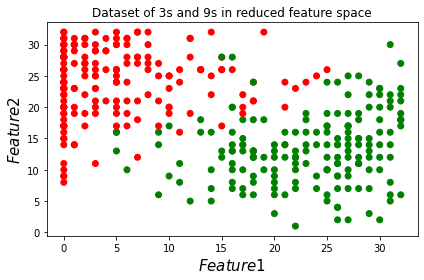

In [10]:
#plt.style.use('_mpl-gallery')
fig, ax = plt.subplots()
color= ['red' if y == 3 else 'green' for y in y_filter]
ax.scatter(reduced_x[:,0], reduced_x[:,1], c=color)

ax.set_xlabel(r'$Feature 1$', fontsize=15)
ax.set_ylabel(r'$Feature 2$', fontsize=15)
ax.set_title('Dataset of 3s and 9s in reduced feature space')

fig.tight_layout()
plt.show()

The two classes don't overlap too much, but are present as two separate clusters as visualised in the plot above. From this we can conclude that the reduced features are informative enough to continue.

# 2. Naive Bayes classifier

In [22]:
def fit_naive_bayes(features, labels, bincount):
  if bincount==0:
      #determine bin width automatically with Freedman-Diaconis rule
      #needs to be added: sort array and then determine IQR for each feature
      iqr_val = np.quantile(features, q=[.25, .75])
      iqr = np.diff(iqr_val)[0]
      print(iqr_val)
      print(features)
      print(iqr)
  else:
    #determine bindwidth and initialize binnings array
      x_max = np.max(features)
      x_min = np.min(features)
      binwidth = (x_max-x_min)/bincount
      binnigns = np.zeros()
  histograms = 0
  binnings = 0
  return histograms, binnings

In [ ]:
def predict_naive_bayes(test_features, histrograms, binnings):

  return predicted_labels

In [23]:
histograms, binning = fit_naive_bayes(X_train, y_train, 0)

[ 0. 10.]
[[ 0.  0.  0. ... 12.  0.  0.]
 [ 0.  0.  9. ...  4.  0.  0.]
 [ 0.  0.  8. ...  8.  0.  0.]
 ...
 [ 0.  0.  0. ... 16.  9.  0.]
 [ 0.  0.  5. ...  2.  0.  0.]
 [ 0.  0.  6. ...  9.  1.  0.]]
10.0


In [ ]:
predicted_labels = predict_naive_bayes(test_features, histograms, binnings)

In [ ]:
#confusion matrix, just use the one from sklearn?

In [ ]:
#create dataset for pixel image
f1 = np.linspace(1, 40, num=40)
f2 = np.linspace(1, 40, num=40)
xx, yy = np.meshgrid(f1,f2)
xx = xx.reshape(1,1600)
yy = yy.reshape(1,1600)
X_plot = np.dstack((xx,yy))
y_plot = predicted_labels
#y_plot = y_plot[:,0]
y_plot = y_plot.reshape(40,40)

#plot the pixel image dataset as decision boundary
fig, ax = plt.subplots()
color= ['red' if y == 1 else 'green' for y in y_test]
ax.imshow(y_plot, alpha = 0.5)

#add the test set data points
ax.scatter(X_test[:,0], X_test[:,1], c=color, marker = "+")

ax.set_xlabel(r'$Feature 1$', fontsize=15)
ax.set_ylabel(r'$Feature 2$', fontsize=15)
ax.set_title('Dataset of 1s and 7s in reduced feature space')

fig.tight_layout()
plt.show()

NameError: ignored